# Model Definition - LSTM - No feature Manipulation
We train a LSTM (Long short term memory) model to perform the task of Time-series forecasting for the **monthly average temperature** and **monthly temperature uncertainity**.

I will forecast fixed number of 'Timesteps' (in months) into the future [1 and 12 chosen for current analysis to forecast for next month and next year]. The 'Timesteps' determine how many steps in past we take as input and same number of steps are forecasted in the past. This is an important point to note here because for other machine learning models we will deal with, I will follow the same forecasting. 

Since, the temperature in the past affect the temperature in future we would try the 'Stateful' LSTM first, meaning dependencies among consecutive batches. But, what if the dependecies are very weak, we would also train the 'Stateless' LSTM and compare the performance for both.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import types
from ibm_botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt

In [2]:
# Importing libraries for training the model and saving it
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras.callbacks import Callback
import h5py

Using TensorFlow backend.


Initializing random seed.

In [3]:
import random
random.seed(1)

#### Loading the Input data

In [5]:
def __iter__(self): return 0
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="",
    config=Config(signature_version='oauth'),
    endpoint_url='')

body = client_e.get_object(Bucket='',Key='Global_temperature_final.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Global_Temp = pd.read_csv(body)
Global_Temp.head()

,Monthly_Uncertainity,Monthly_Temperature,Date
0,1.051,6.704,1850-01-01
1,1.181,8.408,1850-02-01
2,1.102,8.112,1850-03-01
3,0.709,7.332,1850-04-01
4,0.585,7.209,1850-05-01


Convert feature 'Date' to index after converting it into datetime format

In [6]:
Global_Temp['Date']=pd.to_datetime(Global_Temp['Date'])
Global_Temp.set_index('Date',drop=True,inplace=True)

## Data preperation
#### Split data into training and testing data set
We will split the data into 3 groups as follows:
1. 80% training
2. 10% validation
3. 10% testing.

In [7]:
Data,Testing_data=train_test_split(Global_Temp,test_size=0.1,shuffle=False)
Training_data,Validation_data=train_test_split(Data,test_size=0.11,shuffle=False)

#### Create a function to prepare data for model training or prediction 
Take an input time series,

Create a tensor of dimensions [Length X Timesteps X 1], where 'Length' is the number of time-series cuts of size 'Timesteps' (this needs to be exactly divisible by Batch-size for Stateful LSTM model). 

This data tensor is taken by LSTM model for training. 

In [8]:
def Data_preperation(Data,Timesteps,feature):
    #For the Stateful LSTM we need to have [(length of training_data)-timesteps] exactly divisible by the batch-size so that 
    #we can divide the whole training data set into batchs to be supplied for training the model
    length=int((len(Data)-2*Timesteps)/Batch_size)*Batch_size
    #Clipping the training data-set
    Data=Data[:length+Timesteps*2]
    # reshape the data for feature scaling
    Data_1=Data[feature].values.reshape(-1,1)
    # Create x,y data for LSTM training or prediction
    x=[]
    y=[]
    for i in range(Timesteps,length+Timesteps):
        x.append(Data_1[i-Timesteps:i,0])
        y.append(Data_1[i:i+Timesteps,0])
    #Reshaping for LSTM with dimensions [Length X Timesteps X 1]
    #By creating strips of time-series of size of timesteps
    x, y = np.array(x), np.array(y)
    x=np.reshape(x,(x.shape[0],x.shape[1],1))
    y=np.reshape(y,(y.shape[0],y.shape[1],1))
    return x,y

#### Initializing the LSTM Model
We create a 3 layer LSTM network Model.
1. Input layer. Takes the input 'x_train' created by the Data_preperation function.
2. LSTM layer. Fixed number of neurons and either Stateful or Stateless.
3. Dense layer. Takes input from LSTM layer, is a densely connected layer and output space dimensionality is given by 'units'

In [9]:
#create a class to store loss history for training
class LossHistory(Callback):
    def on_train_begin(self,logs={}):
        self.losses=[]
    
    def on_batch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        
def LSTM_Model(x,y,Neurons,Timesteps,LossFunction,Stateful):
    input_layer=Input(batch_shape=(Batch_size,Timesteps,1))
    if Stateful:
        lstm_layer=LSTM(Neurons,stateful=True,return_sequences=True)(input_layer)
    else:
        lstm_layer=LSTM(Neurons,stateful=False,return_sequences=True)(input_layer)
    output_layer=Dense(units=1)(lstm_layer)
    regressor=Model(inputs=input_layer,outputs=output_layer)
    regressor.compile(optimizer='adam',loss=LossFunction)
    lossHistory=LossHistory()
    #Because the LSTM network is stateful therefore I reset the internal states after each epoch.
    for e in range(epochs):
        regressor.fit(x,y,shuffle=False,epochs=1,batch_size=Batch_size,verbose=0,callbacks=[lossHistory])
        regressor.reset_states()
    return regressor

#### Getting the forecast 

In [10]:
def Model_Forecast(x,model):
    ypred=model.predict(x,batch_size=Batch_size)
    return ypred

#### Model Evaluation

We use two different metrics to evaluate our model 

1. Root mean squared error (RMSE).

\begin{align}
RMSE & = \sqrt{\bigg(\frac{\Sigma_i^N (y_{test}^i-y_{pred}^i)^2}{N}\bigg)} \\
\end{align}

2. Mean Absolute error (MAE).

\begin{align}
MAE & = \bigg(\frac{\Sigma_i^N |y_{test}^i-y_{pred}^i|}{N}\bigg) \\
\end{align}

In [11]:
def Model_evaluation(y,yhat):
    RMSE=np.sqrt(mean_squared_error(np.reshape(y,y.shape[0]*y.shape[1],1),np.reshape(yhat,yhat.shape[0]*yhat.shape[1],1)))
    MAE=mean_absolute_error(np.reshape(y,y.shape[0]*y.shape[1],1),np.reshape(yhat,yhat.shape[0]*yhat.shape[1],1))
    return RMSE, MAE 

### Model-fit-score

To find the best model we compare models for the range of above hyperparameters and two different loss functions namely, 'mean absolute error' and 'mean squared error'. Also, we consider two different LSTM model 'Stateful' and 'Stateless' to test whether inter-batch dependency is better for forecasting or not. 

#### Hyper-parameters

In [12]:
Batch_size=64
epochs=100
timesteps=[1,12]
LSTM_neurons=[1,5,10,20,50,100]

#### Hyperparameter Space Grid Search 
I created a function to create LSTM models based on range of hyper-parameters, and then fit it against the training-data set. Next, I create a forecast time-series tensor from validation-data set. Finally, I evaluate the performance by comparing forecasted time-series tensor against the y-validation time-series tensor.  

In [13]:
def HP_Eval_Grid(feature,lossfunction,Stateful):
    RMSE_score=np.zeros((len(timesteps),len(LSTM_neurons)))
    MAE_score=np.zeros((len(timesteps),len(LSTM_neurons)))
    for ts in range(len(timesteps)):
        for neur in range(len(LSTM_neurons)):
            x_train,y_train=Data_preperation(Training_data,Timesteps=timesteps[ts],feature=feature)
            TrainModel=LSTM_Model(x_train,y_train,Timesteps=timesteps[ts],Neurons=LSTM_neurons[neur],LossFunction=lossfunction,Stateful=Stateful)
            x_valid,y_valid=Data_preperation(Validation_data,Timesteps=timesteps[ts],feature=feature)
            y_pred=Model_Forecast(x_valid,model=TrainModel)
            RMSE_score[ts,neur],MAE_score[ts,neur]=Model_evaluation(y_valid,y_pred)
    return RMSE_score, MAE_score

I want to know which model will perform the best forecast for both features time-series, namely, **'Monthly_Temperature'** and **'Monthly_Uncertainity'**. For this I would compare 4 different models based on training model LSTM layer and optimization loss.
1. Stateful LSTM layer with loss described by optimization loss as mean squared error. (Stateful, MSE)
2. Stateful LSTM layer with loss described by optimization loss as mean absolute error. (Stateful, MAE)
3. Stateless LSTM layer with loss described by optimization loss as mean squared error. (Stateless, MSE)
4. Stateless LSTM layer with loss described by optimization loss as mean absolute error. (Stateless, MAE)

In [14]:
Month_Temp_Model11=HP_Eval_Grid(feature='Monthly_Temperature',lossfunction='mse',Stateful=True) 
Month_Temp_Model12=HP_Eval_Grid(feature='Monthly_Temperature',lossfunction='mae',Stateful=True) 
Month_Temp_Model21=HP_Eval_Grid(feature='Monthly_Temperature',lossfunction='mse',Stateful=False) 
Month_Temp_Model22=HP_Eval_Grid(feature='Monthly_Temperature',lossfunction='mae',Stateful=False) 
Month_Unc_Model11=HP_Eval_Grid(feature='Monthly_Uncertainity',lossfunction='mse',Stateful=True) 
Month_Unc_Model12=HP_Eval_Grid(feature='Monthly_Uncertainity',lossfunction='mae',Stateful=True) 
Month_Unc_Model21=HP_Eval_Grid(feature='Monthly_Uncertainity',lossfunction='mse',Stateful=False) 
Month_Unc_Model22=HP_Eval_Grid(feature='Monthly_Uncertainity',lossfunction='mae',Stateful=False) 

#### First, plotting performance measure for Models trained on Monthly_Temperature

([<matplotlib.axis.XTick at 0x7f4b810889b0>,
 <a list of 6 Text xticklabel objects>)

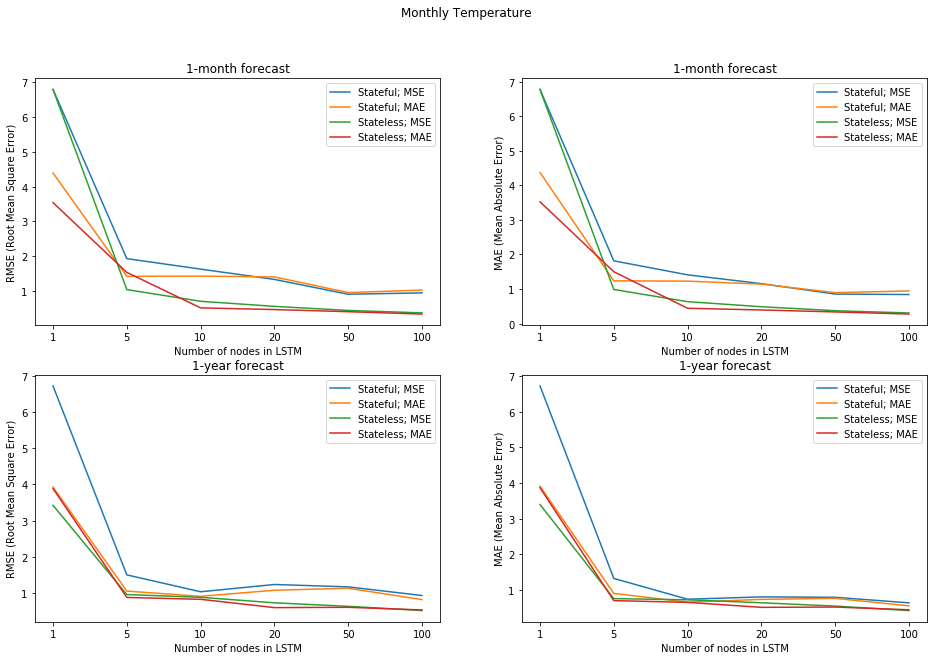

In [17]:
plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle('Monthly Temperature')
plt.subplot(221)
plt.title('1-month forecast', fontsize="12")
plt.plot(Month_Temp_Model11[0][0],label='Stateful; MSE')
plt.plot(Month_Temp_Model12[0][0],label='Stateful; MAE')
plt.plot(Month_Temp_Model21[0][0],label='Stateless; MSE')
plt.plot(Month_Temp_Model22[0][0],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('RMSE (Root Mean Square Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(222)
plt.title('1-month forecast', fontsize="12")
plt.plot(Month_Temp_Model11[1][0],label='Stateful; MSE')
plt.plot(Month_Temp_Model12[1][0],label='Stateful; MAE')
plt.plot(Month_Temp_Model21[1][0],label='Stateless; MSE')
plt.plot(Month_Temp_Model22[1][0],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(223)
plt.title('1-year forecast', fontsize="12")
plt.plot(Month_Temp_Model11[0][1],label='Stateful; MSE')
plt.plot(Month_Temp_Model12[0][1],label='Stateful; MAE')
plt.plot(Month_Temp_Model21[0][1],label='Stateless; MSE')
plt.plot(Month_Temp_Model22[0][1],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('RMSE (Root Mean Square Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(224)
plt.title('1-year forecast', fontsize="12")
plt.plot(Month_Temp_Model11[1][1],label='Stateful; MSE')
plt.plot(Month_Temp_Model12[1][1],label='Stateful; MAE')
plt.plot(Month_Temp_Model21[1][1],label='Stateless; MSE')
plt.plot(Month_Temp_Model22[1][1],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)

#### Next, plotting performance measure for Models trained on Monthly_Uncertainity

([<matplotlib.axis.XTick at 0x7f4b8125d0f0>,
 <a list of 6 Text xticklabel objects>)

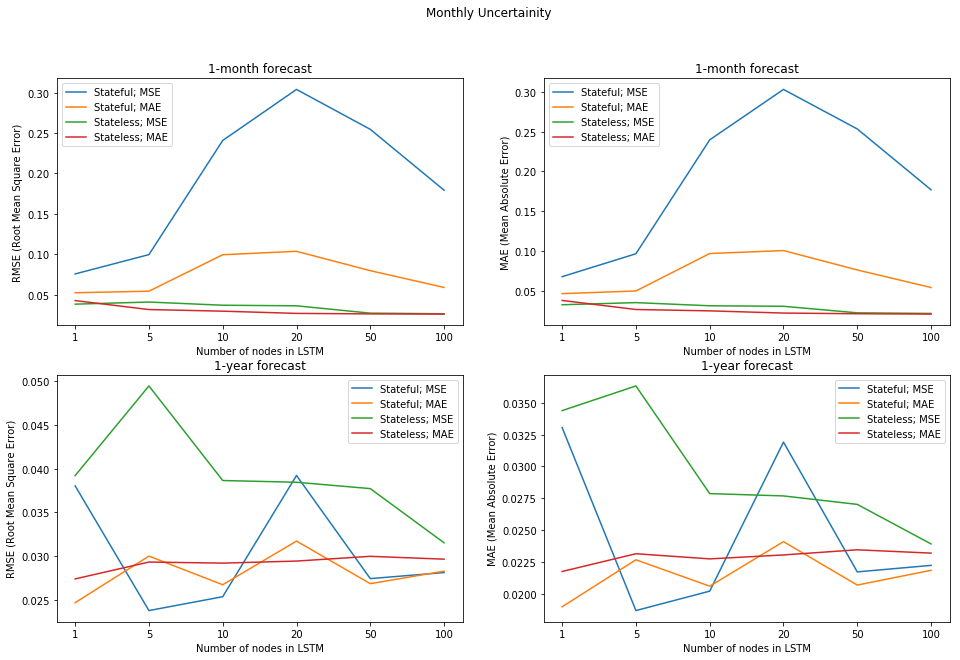

In [16]:
plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle('Monthly Uncertainity')
plt.subplot(221)
plt.title('1-month forecast', fontsize="12")
plt.plot(Month_Unc_Model11[0][0],label='Stateful; MSE')
plt.plot(Month_Unc_Model12[0][0],label='Stateful; MAE')
plt.plot(Month_Unc_Model21[0][0],label='Stateless; MSE')
plt.plot(Month_Unc_Model22[0][0],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('RMSE (Root Mean Square Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(222)
plt.title('1-month forecast', fontsize="12")
plt.plot(Month_Unc_Model11[1][0],label='Stateful; MSE')
plt.plot(Month_Unc_Model12[1][0],label='Stateful; MAE')
plt.plot(Month_Unc_Model21[1][0],label='Stateless; MSE')
plt.plot(Month_Unc_Model22[1][0],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(223)
plt.title('1-year forecast', fontsize="12")
plt.plot(Month_Unc_Model11[0][1],label='Stateful; MSE')
plt.plot(Month_Unc_Model12[0][1],label='Stateful; MAE')
plt.plot(Month_Unc_Model21[0][1],label='Stateless; MSE')
plt.plot(Month_Unc_Model22[0][1],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('RMSE (Root Mean Square Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)
plt.subplot(224)
plt.title('1-year forecast', fontsize="12")
plt.plot(Month_Unc_Model11[1][1],label='Stateful; MSE')
plt.plot(Month_Unc_Model12[1][1],label='Stateful; MAE')
plt.plot(Month_Unc_Model21[1][1],label='Stateless; MSE')
plt.plot(Month_Unc_Model22[1][1],label='Stateless; MAE')
plt.gca().legend()
plt.xlabel('Number of nodes in LSTM')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xticks(np.arange(len(LSTM_neurons)),LSTM_neurons)

### Forecast based on Best Model hyper-parameters

Next, I will show the time-series for both features along with the predictions. For this analysis I did not perform Max-Min scaling in the time-series.

It was understandable to see that if forecast timesteps increase we will see a decline in performance. But it's still interesting to try to predict as far into future we can. To that extent, I will show the predicted time series for 1-month and an year (12-months) as forecast timesteps.

**Starting with the simplest of the cases with 'Timesteps=1' which means that we consider history of 1 timestep and predict next timestep.**

Based on the above plots I choose the following model hyper-parameters:

**'Monthy_Temperature'**: LSTM neurons: 100, Model: Stateless; Loss function for optimizer: Mean Absolute Error

**'Monthy_Uncertainity'**: LSTM neurons: 100, Model: Stateless; Loss function for optimizer: Mean Absolute Error

In [32]:
x_train,y_train=Data_preperation(Training_data,Timesteps=1,feature='Monthly_Temperature')
Model_temp_ts1=LSTM_Model(x_train,y_train,Neurons=100,Timesteps=1,LossFunction='mae',Stateful=False)
x_test1,y_test1=Data_preperation(Testing_data,Timesteps=1,feature='Monthly_Temperature')
y_pred1=Model_Forecast(x_test1,model=Model_temp_ts1)
RMSE_score_best1,MAE_score_best1=Model_evaluation(y_test1,y_pred1)
x_train,y_train=Data_preperation(Training_data,Timesteps=1,feature='Monthly_Uncertainity')
Model_unc_ts1=LSTM_Model(x_train,y_train,Neurons=100,Timesteps=1,LossFunction='mae',Stateful=False)
x_test2,y_test2=Data_preperation(Testing_data,Timesteps=1,feature='Monthly_Uncertainity')
y_pred2=Model_Forecast(x_test2,model=Model_unc_ts1)
RMSE_score_best2,MAE_score_best2=Model_evaluation(y_test2,y_pred2)

Next, let's plot and see how the predicted time-series matchup with the test-data time-series.

Text(0.5,1,'Root Mean Square Error: 0.025 ; Mean Absolute Error: 0.019')

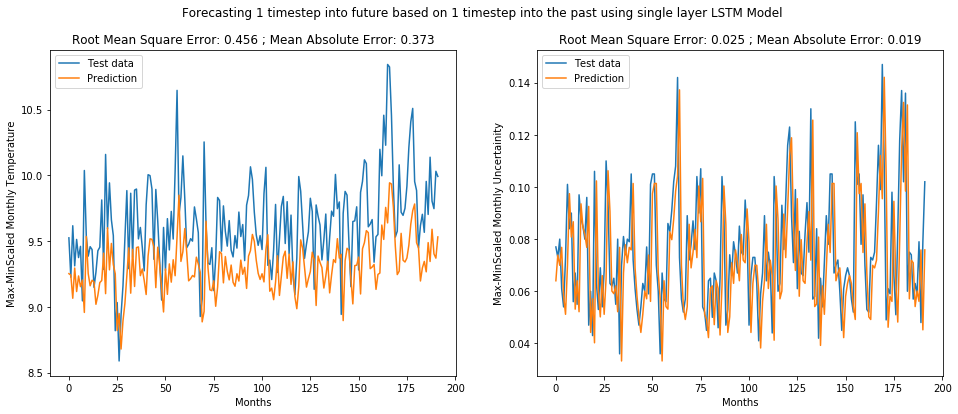

In [33]:
plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Forecasting 1 timestep into future based on 1 timestep into the past using single layer LSTM Model", fontsize="12")
plt.subplot(121)
plt.plot(np.mean(y_test1,axis=1),label="Test data")
plt.plot(np.mean(y_pred1,axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best1,MAE_score_best1))
plt.subplot(122)
plt.plot(np.mean(y_test2,axis=1),label="Test data")
plt.plot(np.mean(y_pred2,axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best2,MAE_score_best2))

#### Next I use 'Timesteps=12' so we are using 1-year data to forecast 1-year in future and present the best model forecast along with the performance measure.
Based on the above plots I choose the following model hyper-parameters:

**'Monthy_Temperature'**: LSTM neurons: 100, Model: Stateless; Loss function for optimizer: Mean Absolute Error

**'Monthy_Uncertainity'**: LSTM neurons: 5, Model: Stateful; Loss function for optimizer: Mean Squared Error

In [34]:
x_train,y_train=Data_preperation(Training_data,Timesteps=12,feature='Monthly_Temperature')
Model_temp_ts12=LSTM_Model(x_train,y_train,Neurons=1,Timesteps=12,LossFunction='mse',Stateful=False)
x_test1,y_test1=Data_preperation(Testing_data,Timesteps=12,feature='Monthly_Temperature')
y_pred1=Model_Forecast(x_test1,model=Model_temp_ts12)
RMSE_score_best1,MAE_score_best1=Model_evaluation(y_test1,y_pred1)
x_train,y_train=Data_preperation(Training_data,Timesteps=12,feature='Monthly_Uncertainity')
Model_unc_ts12=LSTM_Model(x_train,y_train,Neurons=10,Timesteps=12,LossFunction='mse',Stateful=False)
x_test2,y_test2=Data_preperation(Testing_data,Timesteps=12,feature='Monthly_Uncertainity')
y_pred2=Model_Forecast(x_test2,model=Model_unc_ts12)
RMSE_score_best2,MAE_score_best2=Model_evaluation(y_test2,y_pred2)

To see how good is the forecast I plotted the average difference between the yearly predicted data and test-data at each timepoint.

Text(0.5,1,'Root Mean Square Error: 0.042 ; Mean Absolute Error: 0.030')

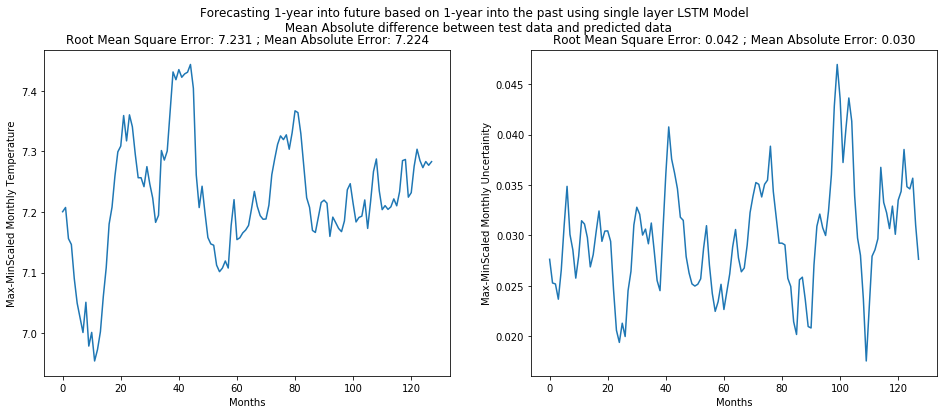

In [35]:
plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Forecasting 1-year into future based on 1-year into the past using single layer LSTM Model \n Mean Absolute difference between test data and predicted data", fontsize="12")
plt.subplot(121)
plt.plot(np.mean(abs(y_test1-y_pred1),axis=1))
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best1,MAE_score_best1))
plt.subplot(122)
plt.plot(np.mean(abs(y_test2-y_pred2),axis=1))
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best2,MAE_score_best2))

Here we can see that at certain time-points the forecast is much better than the others. I show cases when the forecast was the best and the worst.

In [36]:
best_temp_pred_month=np.mean(abs(y_test1-y_pred1),axis=1).argmin()
Worst_temp_pred_month=np.mean(abs(y_test1-y_pred1),axis=1).argmax()
best_unc_pred_month=np.mean(abs(y_test2-y_pred2),axis=1).argmin()
Worst_unc_pred_month=np.mean(abs(y_test2-y_pred2),axis=1).argmax()

Text(0.5,1,'Mean Absolute Error: 0.047')

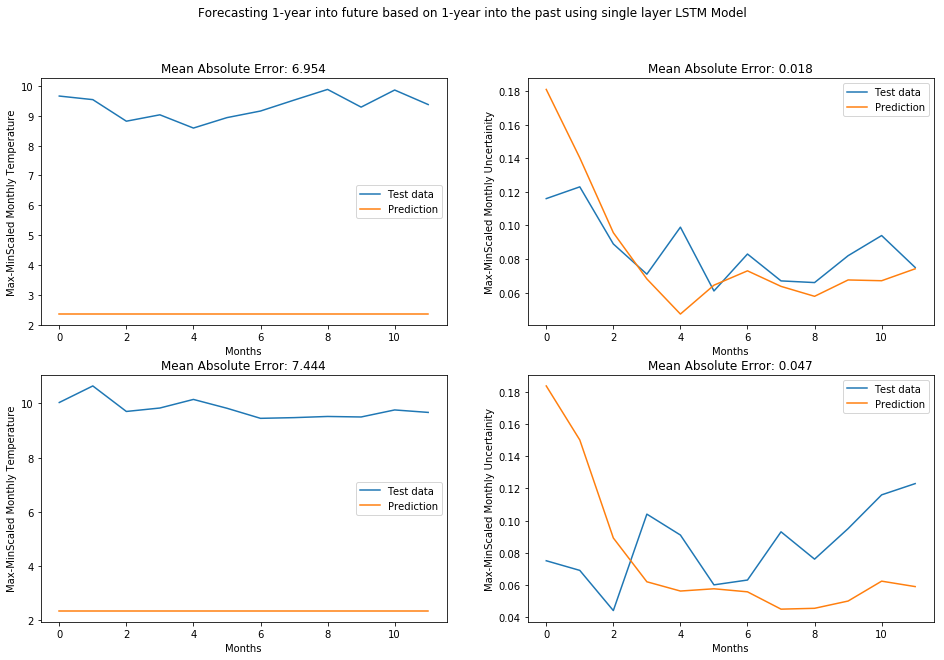

In [37]:
plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Forecasting 1-year into future based on 1-year into the past using single layer LSTM Model", fontsize="12")
plt.subplot(221)
plt.plot(np.mean(y_test1[best_temp_pred_month],axis=1),label="Test data")
plt.plot(np.mean(y_pred1[best_temp_pred_month],axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test1-y_pred1),axis=1).min())
plt.subplot(222)
plt.plot(np.mean(y_test2[best_unc_pred_month],axis=1),label="Test data")
plt.plot(np.mean(y_pred2[best_unc_pred_month],axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test2-y_pred2),axis=1).min())
plt.subplot(223)
plt.plot(np.mean(y_test1[Worst_temp_pred_month],axis=1),label="Test data")
plt.plot(np.mean(y_pred1[Worst_temp_pred_month],axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test1-y_pred1),axis=1).max())
plt.subplot(224)
plt.plot(np.mean(y_test2[Worst_unc_pred_month],axis=1),label="Test data")
plt.plot(np.mean(y_pred2[Worst_unc_pred_month],axis=1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test2-y_pred2),axis=1).max())

#### Let's save the 4 models both feature 'Monthly_Temperature' and 'Monthly_Uncertainity' for forecasting 1-month and 1-year time-series.

In [38]:
credentials_1 = {
    'IBM_API_KEY_ID': '',
    'IAM_SERVICE_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': 'GlobalTemperature.txt'
}
cos = ibm_boto3.client('s3',
                       ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                       ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                       ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                       config=Config(signature_version='oauth'),
                       endpoint_url=credentials_1['ENDPOINT'])
Model_temp_ts1.save("Model_temp_ts1.h5")
Model_unc_ts1.save("Model_unc_ts1.h5")
Model_temp_ts12.save("Model_temp_ts12.h5")
Model_unc_ts12.save("Model_unc_ts12.h5")

In [39]:
with open('Model_temp_ts1.h5', 'rb') as modelfile1:
     cos.upload_fileobj(modelfile1,  credentials_1['BUCKET'], 'Model_temp_ts1.h5')    
with open('Model_unc_ts1.h5', 'rb') as modelfile2:
     cos.upload_fileobj(modelfile2,  credentials_1['BUCKET'], 'Model_unc_ts1.h5')    
with open('Model_temp_ts12.h5', 'rb') as modelfile3:
     cos.upload_fileobj(modelfile3,  credentials_1['BUCKET'], 'Model_temp_ts12.h5')    
with open('Model_unc_ts12.h5', 'rb') as modelfile4:
     cos.upload_fileobj(modelfile4,  credentials_1['BUCKET'], 'Model_unc_ts12.h5')   